In [1]:
# Import necessary libraries
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.preprocessing import OneHotEncoder  

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import import_ipynb
import Tennis_Analysis_Tools as tennis_tools

importing Jupyter notebook from Tennis_Analysis_Tools.ipynb


In [2]:
def preprocess_dataset(betting_data_dfs):
    # Replace 'NR' (Not Ranked) with NaN in 'WRank' and 'LRank' columns
    betting_data_dfs['WRank'].replace('NR', np.nan, inplace=True)
    betting_data_dfs['LRank'].replace('NR', np.nan, inplace=True)
    
    # Convert 'WRank' and 'LRank' columns to numeric, forcing errors to NaN
    betting_data_dfs['WRank'] = pd.to_numeric(betting_data_dfs['WRank'], errors='coerce')
    betting_data_dfs['LRank'] = pd.to_numeric(betting_data_dfs['LRank'], errors='coerce')

    # Fill NaN values in 'WRank' and 'LRank' with 100000 and convert to float
    betting_data_dfs['WRank'] = betting_data_dfs['WRank'].fillna(100000).astype(float)
    betting_data_dfs['LRank'] = betting_data_dfs['LRank'].fillna(100000).astype(float)

    # Create a column indicating if the higher-ranked player won (1 if true, 0 if false)
    betting_data_dfs['higher_rank_won'] = (betting_data_dfs['WRank'] < betting_data_dfs['LRank']).astype(int)

    # Define the essential columns to keep in the dataframe
    essential_columns = [ 'Date', 'WRank', 'LRank', 'higher_rank_won', 'Winner', 'Loser']

    # Filter the dataframe to keep only the essential columns
    betting_data_filtered = betting_data_dfs[essential_columns]

    # Return the preprocessed dataframe
    return betting_data_filtered

In [3]:
def calculate_k(m_i, delta=100, nu=5, sigma=0.1):
    return delta / ((m_i + nu) ** sigma)

In [4]:
def update_elo(winner_elo, loser_elo, games_played_winner, games_played_loser, delta, nu, sigma):
    """
    Update the Elo ratings for a winner and a loser based on the outcome of a game.
    
    """

    # Calculate the dynamic K-factor for both winner and loser based on their games played
    K_winner = calculate_k(games_played_winner, delta, nu, sigma)
    K_loser = calculate_k(games_played_loser, delta, nu, sigma)

    # Calculate the expected probability of the winner winning against the loser
    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))

    # Calculate the change in Elo for both winner and loser
    elo_change_winner = K_winner * (1 - expected_winner)  # Winner's Elo increase
    elo_change_loser = K_loser * (expected_winner - 1)    # Loser's Elo decrease

    # Return the new Elo ratings for winner and loser, along with the expected probability of winning
    return (winner_elo, winner_elo + elo_change_winner, loser_elo, loser_elo + elo_change_loser, expected_winner)

In [5]:
def calculate_elo_with_varied_k_top_players(betting_data_dfs_preprocessed, delta, nu, sigma):
    """
    Simulate tennis matches and update Elo ratings using a dynamic K-factor that adjusts
    based on the number of games played by each player.
    """
    # Initialize Elo scores and games played counters for all players
    players_ids = pd.concat([betting_data_dfs_preprocessed['Winner'], betting_data_dfs_preprocessed['Loser']]).unique()
    elo_scores_varied_k = {player: 1500 for player in players_ids}
    games_played = {player: 0 for player in players_ids}

    # Iterate over each match in the DataFrame
    for i, tennis_match_row in betting_data_dfs_preprocessed.iterrows():
        winner_id, loser_id = tennis_match_row['Winner'], tennis_match_row['Loser']

        # Increment games played by both winner and loser
        games_played[winner_id] += 1
        games_played[loser_id] += 1

        # Retrieve current Elo scores
        winner_elo_before, loser_elo_before = elo_scores_varied_k[winner_id], elo_scores_varied_k[loser_id]

        # Update Elo scores using the dynamic K-factor
        _, winner_elo_after, _, loser_elo_after, _ = update_elo(
            winner_elo_before, loser_elo_before,
            games_played[winner_id], games_played[loser_id],
            delta, nu, sigma)

        # Update Elo scores in the dictionary
        elo_scores_varied_k[winner_id], elo_scores_varied_k[loser_id] = winner_elo_after, loser_elo_after

        # Store pre- and post-match Elo scores, and probability of the winner winning
        betting_data_dfs_preprocessed.at[i, 'winner_elo_before_varied_k'] = winner_elo_before
        betting_data_dfs_preprocessed.at[i, 'winner_elo_after_varied_k'] = winner_elo_after
        betting_data_dfs_preprocessed.at[i, 'loser_elo_before_varied_k'] = loser_elo_before
        betting_data_dfs_preprocessed.at[i, 'loser_elo_after_varied_k'] = loser_elo_after

        # Calculate and store the probability of the winner winning
        prob_winner = 1 / (1 + 10 ** ((loser_elo_before - winner_elo_before) / 400))
        betting_data_dfs_preprocessed.at[i, 'prob_winner_varied_k'] = prob_winner

        # Determine and store match outcomes based on higher-ranked win probabilities
        if tennis_match_row['higher_rank_won'] == 1:
            betting_data_dfs_preprocessed.at[i, 'match_outcome_varied_k'] = int(prob_winner > 0.5)
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked_varied_k'] = prob_winner
        else:
            betting_data_dfs_preprocessed.at[i, 'match_outcome_varied_k'] = int((1 - prob_winner) > 0.5)
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked_varied_k'] = 1 - prob_winner



In [6]:
def accuracy(actual, predictions):
    # Calculate the mean of correct predictions
    logr_accuracy_all_predictors = np.mean(actual == predictions)
    return logr_accuracy_all_predictors

def calibration(actual, predictions):
    # Calculate the ratio of the sum of predictions to the sum of actual outcomes
    return np.sum(predictions) / np.sum(actual)

def logloss(actual, predictions):
    
    # Ensure predictions fall within the range (epsilon, 1 - epsilon)
    epsilon = 1e-15
    predictions = np.clip(predictions, epsilon, 1 - epsilon)

    # Calculate log loss using the cross-entropy formula
    logr_logloss_all_predictors = -(1 / len(actual)) * np.sum(
        actual * np.log(predictions) + (1 - actual) * np.log(1 - predictions))
    return logr_logloss_all_predictors

In [7]:
def evaluate_predictions(actual_outcomes, binary_predictions, probability_predictions):
    # Calculate accuracy to measure how often the binary predictions are correct compared to actual outcomes.
    accuracy_result = accuracy(actual_outcomes, binary_predictions)

    # Calculate calibration to evaluate how well the predicted probabilities align with the actual outcomes.
    calibration_result = calibration(actual_outcomes, probability_predictions)

    # Calculate log loss to assess the accuracy of the probability predictions, penalizing those far from the actual results.
    logloss_result = logloss(actual_outcomes, probability_predictions)

    # Return the calculated metrics as a dictionary for easy access and further analysis.
    return {
        "accuracy": accuracy_result,
        "calibration": calibration_result,
        "log_loss": logloss_result
    }

In [8]:
# Initialize a dictionary to store dataframes for each year
betting_data_dfs = {}

In [9]:
# Loop through each year from 2005 to 2019
for current_year in range(2005, 2020): 
    # Determine the file extension based on the year
    file_extension = 'xls' if current_year < 2013 else 'xlsx'
    
    # Construct the file path using the determined file extension
    file_path = f"/Users/harishthota/Desktop/UOA Project/Betting_Odds_Tennis/{current_year}.{file_extension}"
    
    # Read the Excel file and store it in the dictionary with the year as the key
    betting_data_dfs[current_year] = pd.read_excel(file_path)

In [10]:
betting_data_dfs[2019]

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Dimitrov G.,...,0.0,Completed,1.36,3.00,1.36,3.37,1.42,3.60,1.35,3.18
1,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Raonic M.,...,0.0,Completed,1.18,4.50,1.23,4.68,1.27,4.84,1.22,4.26
2,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Kecmanovic M.,...,0.0,Completed,1.57,2.25,1.67,2.32,1.71,2.40,1.63,2.28
3,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Millman J.,...,1.0,Completed,1.40,2.75,1.41,3.13,1.45,3.20,1.40,2.95
4,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Uchiyama Y.,...,0.0,Completed,2.62,1.44,2.73,1.51,3.26,1.53,2.69,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Nadal R.,...,1.0,Completed,1.44,2.75,1.39,3.26,1.48,3.30,1.41,2.93
2606,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,...,0.0,Completed,1.90,1.90,2.14,1.79,2.24,2.06,1.92,1.90
2607,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Tsitsipas S.,...,0.0,Completed,3.50,1.30,3.75,1.33,3.75,1.40,3.39,1.33
2608,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Thiem D.,...,0.0,Completed,1.80,2.00,1.84,2.10,1.87,2.20,1.78,2.06


In [11]:
# Combine DataFrames from all years into a single DataFrame, reindexing rows.
betting_data_dfs = pd.concat(betting_data_dfs.values(), ignore_index = True)

In [12]:
# Display a summary of the DataFrame to understand its structure and data types
betting_data_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         40390 non-null  int64         
 1   Location    40390 non-null  object        
 2   Tournament  40390 non-null  object        
 3   Date        40390 non-null  datetime64[ns]
 4   Series      40390 non-null  object        
 5   Court       40390 non-null  object        
 6   Surface     40390 non-null  object        
 7   Round       40390 non-null  object        
 8   Best of     40390 non-null  int64         
 9   Winner      40390 non-null  object        
 10  Loser       40390 non-null  object        
 11  WRank       40375 non-null  float64       
 12  LRank       40303 non-null  float64       
 13  WPts        38701 non-null  float64       
 14  LPts        38631 non-null  float64       
 15  W1          40155 non-null  float64       
 16  L1          40157 non-

In [13]:
# Generate descriptive statistics for numerical columns in the DataFrame
betting_data_dfs.describe()

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W4,L4,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
count,40390.000000,40390.000000,40375.000000,40303.000000,38701.000000,38631.000000,40155.000000,40157.000000,3647.000000,3647.000000,...,10671.000000,10671.000000,28131.000000,28142.000000,15572.000000,15579.000000,25354.000000,25354.000000,25354.000000,25354.000000
mean,32.974944,3.378311,57.801536,90.384860,1828.537195,1054.728379,5.801992,4.075155,5.783384,3.865643,...,1.815867,3.542479,1.810226,3.451461,1.796538,3.557943,1.998610,7.847864,1.838168,3.547658
std,18.006138,0.783274,72.735132,115.423997,2278.996487,1212.422674,1.232787,1.841617,1.262227,1.903181,...,0.996238,3.646316,1.031691,3.075889,1.004273,3.272510,1.582432,376.246830,1.089277,3.227770
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.010000,1.020000,1.000000,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000
25%,19.000000,3.000000,16.000000,34.000000,645.000000,502.000000,6.000000,3.000000,6.000000,2.000000,...,1.240000,1.750000,1.250000,1.730000,1.220000,1.730000,1.300000,1.840000,1.250000,1.740000
50%,33.000000,3.000000,40.000000,64.000000,1010.000000,745.000000,6.000000,4.000000,6.000000,4.000000,...,1.500000,2.500000,1.500000,2.500000,1.500000,2.630000,1.580000,2.750000,1.510000,2.530000
75%,49.000000,3.000000,75.000000,102.000000,1890.000000,1150.000000,6.000000,6.000000,6.000000,6.000000,...,2.030000,3.850000,2.000000,4.000000,2.000000,4.000000,2.210000,4.470000,2.070000,3.910000
max,67.000000,5.000000,1890.000000,2159.000000,16950.000000,16950.000000,7.000000,7.000000,7.000000,7.000000,...,18.000000,60.000000,26.000000,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000


In [14]:
# Retrieve and display the column names of the DataFrame
betting_data_dfs.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts',
       'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets',
       'Lsets', 'Comment', 'B365W', 'B365L', 'CBW', 'CBL', 'EXW', 'EXL', 'IWW',
       'IWL', 'PSW', 'PSL', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW',
       'MaxL', 'AvgW', 'AvgL'],
      dtype='object')

In [15]:
# Apply preprocessing to the betting dataset 
betting_data_dfs_preprocessed = preprocess_dataset(betting_data_dfs) 

# Display the preprocessed DataFrame to verify the applied transformations
betting_data_dfs_preprocessed

,Date,WRank,LRank,higher_rank_won,Winner,Loser
0,2005-01-03,53.0,324.0,1,Saulnier C.,Baccanello P.
1,2005-01-03,72.0,82.0,1,Enqvist T.,Sluiter R.
2,2005-01-03,39.0,45.0,1,Melzer J.,Berdych T.
3,2005-01-03,66.0,79.0,1,Rochus O.,Dupuis A.
4,2005-01-03,35.0,101.0,1,Mayer F.,Arthurs W.
...,...,...,...,...,...,...
40385,2019-11-15,1.0,6.0,1,Nadal R.,Tsitsipas S.
40386,2019-11-15,7.0,4.0,0,Zverev A.,Medvedev D.
40387,2019-11-16,6.0,3.0,0,Tsitsipas S.,Federer R.
40388,2019-11-16,5.0,7.0,1,Thiem D.,Zverev A.


In [16]:
betting_data_dfs_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             40390 non-null  datetime64[ns]
 1   WRank            40390 non-null  float64       
 2   LRank            40390 non-null  float64       
 3   higher_rank_won  40390 non-null  int64         
 4   Winner           40390 non-null  object        
 5   Loser            40390 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.8+ MB


In [17]:
# Calculate the mean of each numeric column in the preprocessed dataset to handle missing values
means = betting_data_dfs_preprocessed.select_dtypes(include=[np.number]).mean()

# Fill missing values in the DataFrame with the computed means for each corresponding numeric column
betting_data_dfs_preprocessed.fillna(means, inplace=True)

In [18]:
# Apply preprocessing steps to the dataset 
betting_data_dfs_preprocessed = preprocess_dataset(betting_data_dfs)

In [19]:
# Display information about the betting_data_dfs_preprocessed DataFrame 
# including the data types and non-null counts to assess data quality and structure
betting_data_dfs_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             40390 non-null  datetime64[ns]
 1   WRank            40390 non-null  float64       
 2   LRank            40390 non-null  float64       
 3   higher_rank_won  40390 non-null  int64         
 4   Winner           40390 non-null  object        
 5   Loser            40390 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.8+ MB


In [20]:
# Calculate the mean of each numeric column in the preprocessed dataset to use for filling missing values
means = betting_data_dfs_preprocessed.select_dtypes(include=[np.number]).mean()

# Fill missing values in the DataFrame with the computed means for each corresponding numeric column
betting_data_dfs_preprocessed.fillna(means, inplace=True)

In [21]:
# Collect unique player IDs from both 'Winner' and 'Loser' columns to create a comprehensive list of players
players_ids = pd.concat([betting_data_dfs_preprocessed['Winner'], betting_data_dfs_preprocessed['Loser']]).unique()

In [22]:
# Set a cutoff date for data splitting and configure pandas to display all columns of DataFrames
split_time = '2018-12-31'
pd.set_option('display.max_columns', None)

In [23]:
# Filter the preprocessed betting data to create a validation set with matches occurring after the specified split date
betting_data_dfs_preprocessed_validation = betting_data_dfs_preprocessed[betting_data_dfs_preprocessed.Date > split_time]
betting_data_dfs_preprocessed_validation

,Date,WRank,LRank,higher_rank_won,Winner,Loser
37785,2019-01-01,63.0,49.0,0,Kudla D.,Fritz T.
37786,2019-01-01,40.0,57.0,1,Chardy J.,Struff J.L.
37787,2019-01-01,240.0,234.0,0,Murray A.,Duckworth J.
37788,2019-01-01,35.0,62.0,1,Kyrgios N.,Harrison R.
37789,2019-01-01,239.0,146.0,0,Tsonga J.W.,Kokkinakis T.
...,...,...,...,...,...,...
40385,2019-11-15,1.0,6.0,1,Nadal R.,Tsitsipas S.
40386,2019-11-15,7.0,4.0,0,Zverev A.,Medvedev D.
40387,2019-11-16,6.0,3.0,0,Tsitsipas S.,Federer R.
40388,2019-11-16,5.0,7.0,1,Thiem D.,Zverev A.


In [24]:
def grid_search_elo(df, delta_values, nu_values, sigma_values):
    """
    Conducts a grid search over specified ranges of delta, nu, and sigma parameters to find the optimal settings
    for an Elo rating system based on given metrics such as accuracy, calibration, and log loss.
    """
    results = []  # Initialize a list to store the results of each parameter combination

    # Iterate over all combinations of delta, nu, and sigma values
    for delta in delta_values:
        for nu in nu_values:
            for sigma in sigma_values:
                # Make a copy of the original DataFrame to avoid modifying it directly
                df_copy = df.copy()

                # Calculate Elo ratings with the current set of parameters
                calculate_elo_with_varied_k_top_players(df_copy, delta, nu, sigma)

                # Filter the data for validation based on date, considering matches after December 31, 2018
                df_validation = df_copy[df_copy.Date > '2018-12-31']
                
                top_50_players = tennis_tools.precompute_top_players(betting_data_dfs_preprocessed, 50)
                top_100_players = tennis_tools.precompute_top_players(betting_data_dfs_preprocessed, 100)

                # Determine matches involving top 50 and top 100 players of 2019 for both winner and loser
                df_validation['Top50'] = df_validation.apply(
                    lambda row: row['Winner'] in top_50_players[2019] and row['Loser'] in top_50_players[2019], axis=1)
                df_validation['Top100'] = df_validation.apply(
                    lambda row: row['Winner'] in top_100_players[2019] and row['Loser'] in top_100_players[2019], axis=1)

                # Filter the validation data for top 50 and top 100 players
                df_validation_top_50 = df_validation[df_validation['Top50']]
                df_validation_top_100 = df_validation[df_validation['Top100']]

                # Evaluate predictions for top 50 and top 100 players and compute accuracy, calibration, and log loss
                accuracy_top50, calibration_top50, log_loss_top50 = tennis_tools.evaluate_predictions(
                    df_validation_top_50["higher_rank_won"],
                    df_validation_top_50["match_outcome_varied_k"], 
                    df_validation_top_50['prob_high_ranked_varied_k']
                )
                accuracy_top100,calibration_top100, log_loss_top100  = tennis_tools.evaluate_predictions(
                    df_validation_top_100["higher_rank_won"],
                    df_validation_top_100["match_outcome_varied_k"], 
                    df_validation_top_100['prob_high_ranked_varied_k']
                )

                # Store results including parameter set and evaluation metrics for top 50 players
                result_top50 = {
                    "delta": delta,
                    "nu": nu,
                    "sigma": sigma,
                    "dataset": "Top 50",
                    "accuracy": accuracy_top50,  
                    "calibration": calibration_top50,
                    "log_loss": log_loss_top50
                }
                # Store results including parameter set and evaluation metrics for top 100 players
                result_top100 = {
                    "delta": delta,
                    "nu": nu,
                    "sigma": sigma,
                    "dataset": "Top 100",
                    "accuracy": accuracy_top100,  
                    "calibration": calibration_top100,
                    "log_loss": log_loss_top100
                }
                # Append results for both top 50 and top 100 to the results list
                results.extend([result_top50, result_top100])

    # Convert the list of results into a DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    return results_df


In [25]:
# Define ranges of parameters to explore in the grid search for the Elo rating system
delta_values = list(range(90, 170, 5))
nu_values = list(range(20, 80, 5))      
sigma_values = [x / 100 for x in range(15, 50, 5)] 

# Perform a grid search to find the optimal Elo rating parameters using predefined ranges
results_df = grid_search_elo(betting_data_dfs_preprocessed, delta_values, nu_values, sigma_values)

# Filter results for Top 50 players and identify the best parameters set with the lowest log loss
best_params_top50 = results_df[(results_df['dataset'] == 'Top 50') & (results_df['log_loss'] == results_df[results_df['dataset'] == 'Top 50']['log_loss'].min())]

# Filter results for Top 100 players and identify the best parameters set with the lowest log loss
best_params_top100 = results_df[(results_df['dataset'] == 'Top 100') & (results_df['log_loss'] == results_df[results_df['dataset'] == 'Top 100']['log_loss'].min())]

# Retrieve the best accuracy, calibration, and log loss metrics associated with the optimal parameters for Top 50 players
best_metrics_top50 = best_params_top50[['accuracy', 'calibration', 'log_loss']].iloc[0]

# Retrieve the best accuracy, calibration, and log loss metrics associated with the optimal parameters for Top 100 players
best_metrics_top100 = best_params_top100[['accuracy', 'calibration', 'log_loss']].iloc[0]


In [26]:
results_df.tail()

,delta,nu,sigma,dataset,accuracy,calibration,log_loss
2683,165,75,0.35,Top 100,0.5614,1.2002,0.7161
2684,165,75,0.40,Top 50,0.5000,1.2658,0.8153
2685,165,75,0.40,Top 100,0.5614,1.2107,0.7221
2686,165,75,0.45,Top 50,0.5000,1.2753,0.8160
2687,165,75,0.45,Top 100,0.5439,1.2193,0.7296


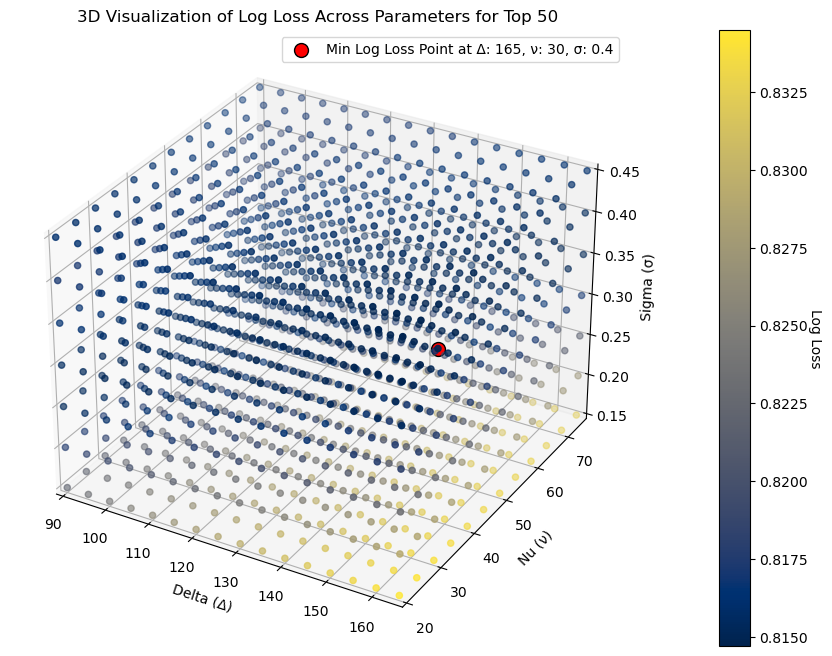

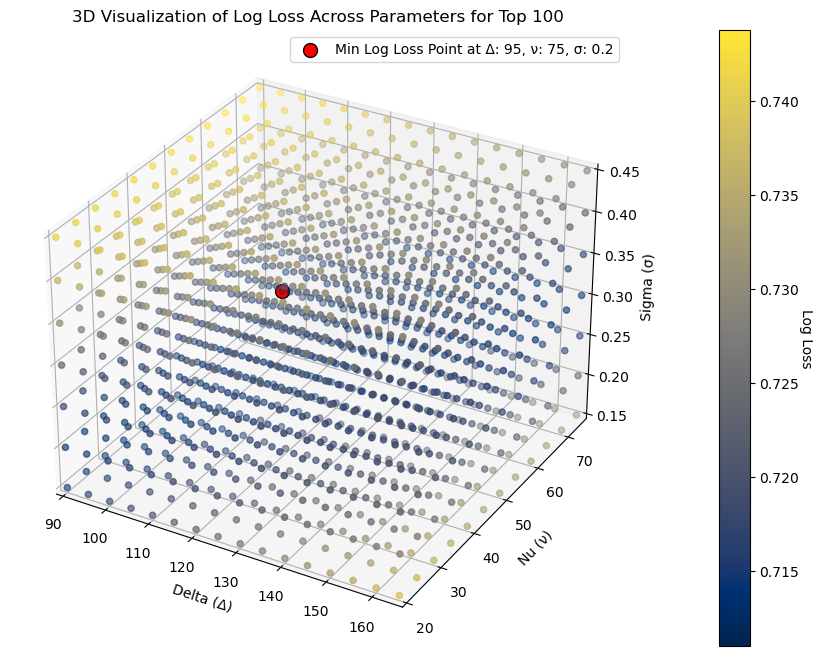

In [110]:
def plot_3d_scatter(df, dataset_label):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Extract data
    X = df['delta']
    Y = df['nu']
    Z = df['sigma']
    log_loss_values = df['log_loss']
    accuracies = df['accuracy']
    calibrations = df['calibration']

    # 3D scatter plot
    sc = ax.scatter(X, Y, Z, c=log_loss_values, cmap='cividis', marker='o')

    # Find minimum log loss index
    min_loss_index = log_loss_values.idxmin()
    min_X = X[min_loss_index]
    min_Y = Y[min_loss_index]
    min_Z = Z[min_loss_index]
    min_accuracy = accuracies[min_loss_index]
    min_calibration = calibrations[min_loss_index]
    min_log_loss = log_loss_values[min_loss_index]

    # Highlight the minimum log loss point
    ax.scatter(min_X, min_Y, min_Z, color='red', s=100, edgecolor='black', label=f'Min Log Loss Point at Δ: {min_X}, ν: {min_Y}, σ: {min_Z}', zorder=5)


    # Axis settings
    ax.set_xlim([X.min(), X.max()])
    ax.set_ylim([Y.min(), Y.max()])
    ax.set_zlim([Z.min(), Z.max()])
    ax.set_xlabel('Delta (Δ)')
    ax.set_ylabel('Nu (ν)')
    ax.set_zlabel('Sigma (σ)')
    ax.set_title(f'3D Visualization of Log Loss Across Parameters for {dataset_label}')

    # Color bar
    cbar = plt.colorbar(sc, pad=0.1)
    cbar.set_label('Log Loss', rotation=270, labelpad=10)

    # Legend
    ax.legend(loc='upper right')

    plt.show()

# Example usage assuming df_top50 and df_top100 are defined
plot_3d_scatter(df_top50, "Top 50")
plot_3d_scatter(df_top100, "Top 100")

In [111]:
df_top50

,delta,nu,sigma,dataset,accuracy,calibration,log_loss
0,90,20,0.15,Top 50,0.3846,1.2382,0.8221
2,90,20,0.20,Top 50,0.3846,1.2427,0.8176
4,90,20,0.25,Top 50,0.4231,1.2523,0.8153
6,90,20,0.30,Top 50,0.5000,1.2640,0.8155
8,90,20,0.35,Top 50,0.5000,1.2739,0.8166
...,...,...,...,...,...,...,...
2678,165,75,0.25,Top 50,0.3846,1.2357,0.8213
2680,165,75,0.30,Top 50,0.3846,1.2422,0.8169
2682,165,75,0.35,Top 50,0.4615,1.2535,0.8150
2684,165,75,0.40,Top 50,0.5000,1.2658,0.8153


In [100]:
print(f"Best Metrics for 538 Model for top 50 players \n\n{best_metrics_top50}")

Best Metrics for 538 Model for top 50 players 

accuracy       0.5000
calibration    1.2611
log_loss       0.8147
Name: 2558, dtype: float64


In [99]:
print(f"Best Metrics for 538 Model for top 100 players \n\n{best_metrics_top100}")

Best Metrics for 538 Model for top 100 players 

accuracy       0.5439
calibration    1.1922
log_loss       0.7110
Name: 325, dtype: float64
